In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#### In notebook 01_general_data, the rankings data was added to the dataframe. In this notebook, we will select a small amount of ranking systems and create columns for each of the selected rankings systems.

In [ ]:
#import the team data dataframe from notebook 01_general_data
team_data= pd.read_csv("team_data.csv")

#### There are over 200 ranking systems represented in the data. Not every system began at the beginning of the time in which the data spans. Some ranking systems are no longer in existence.
#### Count the number of entries each ranking system is used. The more entries a rankings system has, the more likely it is able to serve the model. 


In [4]:
team_data['SystemName'].value_counts().head(10)

WLK    1197
DOL    1197
COL    1197
SAG    1197
POM    1197
MOR    1197
BIH    1132
WOB    1132
WOL    1130
RTH    1130
Name: SystemName, dtype: int64

#### EDA: Plot number of tournament wins vs rank. This plot is across ALL ranking systems represented in the data. 
#### The trend is as expected where the higher the ranking a team has, the less wins the team is expected to achieve in the tournament. 
#### It is noted that the correlation is apparent at higher ranks; however at lower ranks a team is capable of falling in any class (0-6 wins).
#### It is noted that ranking does not appear to be highly correlated in the middle range of number of wins (3-5 wins). 

<AxesSubplot:xlabel='T_Wins', ylabel='OrdinalRank'>

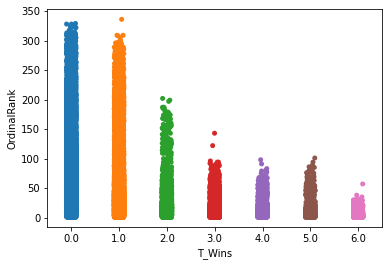

In [5]:
sns.stripplot(data=team_data, x = 'T_Wins', y='OrdinalRank')

In [6]:
import warnings
warnings.filterwarnings('ignore')

#### The target feature (number of tournmanet wins) is highly imbalanced, as is expected. For every team that wins the championship (6 wins), there are 32 teams that lose in the first round (0 wins).

#### The data shows that the number of wins of a class is approximately half of the number of wins of the previous class. 

####    -If the data was 100% complete. The relative amount of entries in each class would be EXACTLY half of its preceeding.
####    - It is noted that the exception to the above statement is between the 5 wins and 6 wins classes. This is expected since there is no 7 wins class. While two teams earn 5 wins. One of these teams will alo earn a 6th win. So with 100% complete data. The 5 wins class and 6 wins class would have EQUAL number of entries. 

In [7]:
team_data['T_Wins'].value_counts()

0.0    29558
1.0    16691
2.0     7533
3.0     3977
4.0     1727
5.0      997
6.0      956
Name: T_Wins, dtype: int64

In [7]:
#pip install -U imbalanced-learn

#### Test rough models to determine which ranking system(s) will best serve the predictive model. 
#### The six ranking systems [POM, MOR, SAG, COL, DOL, WLK] with the maximum number of entries (1197) are considered.
#### Additionally, based on literature, the BPI and MAS ranking systems are industry leading in addition to some of the six ranking systems above. BPI and MAS are also considered.

In [21]:
system_counts = pd.DataFrame(team_data['SystemName'].value_counts())
list_of_max_entries = list(system_counts.index[system_counts['SystemName']==team_data['SystemName'].value_counts().max()])
list_of_max_entries = list(system_counts.index[system_counts['SystemName']==team_data['SystemName'].value_counts().max()])
systems = list_of_max_entries
systems.append('MAS')
systems.append('BPI')
systems

['WLK', 'DOL', 'COL', 'SAG', 'POM', 'MOR', 'MAS', 'BPI']

##### Oversample the data to compensate for the imbalanced data as discussed above.

In [8]:
#from imblearn.over_sampling import RandomOverSampler
#sampler = RandomOverSampler()

In [125]:
from imblearn.over_sampling import SMOTE
smote=SMOTE()

#### Prepare to scale and normalize the data

In [124]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

##### Import various classification model types and model evaluation tools

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [11]:
from sklearn.model_selection import cross_val_score

In [109]:
models = [MultinomialNB(), RandomForestClassifier(n_estimators=100), KNeighborsClassifier(n_neighbors=17), svm.SVC(kernel='linear'), LogisticRegression(solver='lbfgs')]


#### Calculate the cross validation score of each ranking system for the potential classificaiton model types. RandomForestClassifer scores the best.

In [131]:
score_dict={}
for system in systems:
    score_list = []
    model_list=[]
    df = team_data[team_data['SystemName']==system]
    X = df['OrdinalRank']#.array().reshape(-1, 1)
    X = np.reshape(list(X), (X.shape[0],1))
    y = df['T_Wins']
    y = np.reshape(list(y), (y.shape[0],1))
    #X , y = sampler.fit_resample(X,y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=101)
    X_train , y_train = sampler.fit_resample(X_train,y_train)
    X_train, y_train = smote.fit_resample(X_train,y_train)
    for model in models:
        score = cross_val_score(model, X_train, y_train).mean()
        #score=scores.mean()
        score_list.append(score)
        model_list.append(model.__str__())
    score_dict[system.__str__()] = score_list
score_df = pd.DataFrame.from_dict(score_dict, orient='index', columns = model_list)
score_df

,MultinomialNB(),RandomForestClassifier(),KNeighborsClassifier(n_neighbors=17),SVC(kernel='linear'),LogisticRegression()
WLK,0.142450,0.481490,0.297121,0.289369,0.317864
DOL,0.142450,0.474158,0.279621,0.312583,0.313814
COL,0.142450,0.471731,0.288583,0.300378,0.298341
SAG,0.142450,0.485162,0.317474,0.288571,0.320719
POM,0.142450,0.511620,0.299951,0.289795,0.321951
MOR,0.142450,0.523810,0.285718,0.294266,0.281245
MAS,0.140772,0.522394,0.311772,0.284159,0.284161
BPI,0.138485,0.702634,0.574400,0.279795,0.275426


In [133]:
model=RandomForestClassifier(n_estimators=100)
for system in systems:
    df = team_data[team_data['SystemName']==system]
    X = df['OrdinalRank']#.array().reshape(-1, 1)
    X = np.reshape(list(X), (X.shape[0],1))
    scaled_X = scaler.fit_transform(X)
    scaled_X = pd.DataFrame(scaled_X)
    y = df['T_Wins']
    y = np.reshape(list(y), (y.shape[0],1))
    #X , y = sampler.fit_resample(X,y)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.4, stratify=y, random_state=101)
    X_train , y_train = sampler.fit_resample(X_train,y_train)
    X_train, y_train = smote.fit_resample(X_train,y_train)
    model.fit(X_train, y_train)
    y_predict=model.predict(X_test)
    ac=accuracy_score(y_predict,y_test)
    cm=confusion_matrix(y_test, y_predict)
    cr=classification_report(y_test, y_predict)
    score = cross_val_score(model, X_train, y_train)
    print(f'{system }{ model}Train Score: {model.score(X_train, y_train)}')
    print(f'{system }{ model}Test Score: {model.score(X_test, y_test)}')
    print(f'{system }{ model}Accuracy: {ac}')
    print(f'{system }{ model}Confusion Matrix: \n {cm}')
    print(f'{system }{ model}Classification Report: \n {cr}')
    print(f'{system }{ model}Cross Validation Score: \n {score}')
    

WLKRandomForestClassifier()Train Score: 0.5156695156695157
WLKRandomForestClassifier()Test Score: 0.3277661795407098
WLKRandomForestClassifier()Accuracy: 0.3277661795407098
WLKRandomForestClassifier()Confusion Matrix: 
 [[116  46  19  30   8   8   7]
 [ 32  24  26  12  10  15  10]
 [  9   5   9   8   9  10   8]
 [  3   0   1   1  10  11   4]
 [  1   1   1   2   3   1   4]
 [  0   2   1   0   2   2   1]
 [  0   0   0   0   2   3   2]]
WLKRandomForestClassifier()Classification Report: 
               precision    recall  f1-score   support

         0.0       0.72      0.50      0.59       234
         1.0       0.31      0.19      0.23       129
         2.0       0.16      0.16      0.16        58
         3.0       0.02      0.03      0.02        30
         4.0       0.07      0.23      0.11        13
         5.0       0.04      0.25      0.07         8
         6.0       0.06      0.29      0.09         7

    accuracy                           0.33       479
   macro avg       0.2

#### ESPN's BPI is a popular predictive ranking system. We can see it scores better than the other popular models we tried. However, we will not consider using BPI as we only have data from 2009 to 2013. Future work includes to complete this data and see if the predictive performance holds true.


In [119]:
team_data[team_data['SystemName']=='BPI']['SystemName'].count()

334

In [120]:
team_data[team_data['SystemName']=='BPI']['Season'].unique()

array([2009, 2010, 2011, 2012, 2013])

#### Since MAS ranking system does not score significantly better than the other considered models, MAS ranking system will also be omitted, as to not lose any data or create NaN data. Only the six ranking systems with maximum entries will be used for the final predictive model. 

In [136]:
# Create a list of the six ranking systems with maximum entries
x = pd.DataFrame(team_data['SystemName'].value_counts())
list_of_max_entries = list(x.index[x['SystemName']==team_data['SystemName'].value_counts().max()])

In [137]:
filtered_rankings = team_data[team_data.SystemName.isin(list_of_max_entries)]

In [138]:
filtered_rankings

,Unnamed: 0,Season,Seed,TeamID,TeamName,RankingDayNum,SystemName,OrdinalRank,Wins,Losses,Win%,T_Wins
5,5,2003,1,1328,Oklahoma,133,COL,3,24,6,80.0000,3.0
6,6,2003,1,1328,Oklahoma,133,DOL,6,24,6,80.0000,3.0
19,19,2003,1,1328,Oklahoma,133,MOR,6,24,6,80.0000,3.0
20,20,2003,1,1328,Oklahoma,133,POM,9,24,6,80.0000,3.0
23,23,2003,1,1328,Oklahoma,133,SAG,8,24,6,80.0000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
61398,61398,2021,16,1216,Hartford,133,DOL,156,15,8,65.2174,0.0
61416,61416,2021,16,1216,Hartford,133,MOR,146,15,8,65.2174,0.0
61421,61421,2021,16,1216,Hartford,133,POM,189,15,8,65.2174,0.0
61426,61426,2021,16,1216,Hartford,133,SAG,186,15,8,65.2174,0.0


#### Create a column for each of the six ranking systems

In [139]:
team_data_clean = filtered_rankings
for system in list_of_max_entries:
    entry = filtered_rankings[filtered_rankings['SystemName']==system][['Season', 'TeamID', 'OrdinalRank']]
    entry = entry.rename(columns={'OrdinalRank':(f'Rank_{system}')})
    team_data_clean = entry.merge(team_data_clean, how='inner', on=['TeamID', 'Season']) 
    #team_data_clean = team_data_clean.drop(['SystemName','OrdinalRank', 'Unnamed: 0'], axis=1)
team_data_clean.drop(['SystemName','OrdinalRank', 'Unnamed: 0', 'RankingDayNum'], axis=1, inplace=True)

#### The above code created six identical rows (one fir wach ranking system) fir a give TeamID and Season pair. Drop the duplicate rows.

In [141]:
team_data_clean.drop_duplicates(inplace=True)

#### Export team data dataframe (cleaned with only six ranking system and a column for each one) to csv. This will be combined with the team data dataframe in another notebook. More features will be added to this dataframe in another notebook.

In [265]:
team_data_clean.to_csv('team_data_clean.csv')

In [142]:
team_data_clean

,Season,TeamID,Rank_MOR,Rank_POM,Rank_SAG,Rank_COL,Rank_DOL,Rank_WLK,Seed,TeamName,Wins,Losses,Win%,T_Wins
0,2003,1328,6,9,8,3,6,8,1,Oklahoma,24,6,80.0000,3.0
6,2003,1448,20,12,9,8,4,9,2,Wake Forest,24,5,82.7586,1.0
12,2003,1393,21,15,12,9,5,14,3,Syracuse,24,5,82.7586,6.0
18,2003,1257,14,14,6,6,16,6,4,Louisville,24,6,80.0000,1.0
24,2003,1280,8,11,16,25,19,17,5,Mississippi St,21,9,70.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7152,2021,1457,50,91,87,52,49,83,12,Winthrop,23,1,95.8333,0.0
7158,2021,1317,94,71,84,85,88,78,13,North Texas,16,9,64.0000,1.0
7164,2021,1159,41,84,67,14,16,10,14,Colgate,14,1,93.3333,0.0
7170,2021,1331,130,151,152,181,150,151,15,Oral Roberts,13,10,56.5217,2.0
